# Spatially varying parameters - Mark

## Objectives

The main objective of this tutorial is to demonstrate how spatially varying parameters can be used to model and simulate different geometries and/or materials using JOOMMF. I have modified this notebook in order to simulate a structure similar to the core-shell particle from Anderson and Camley paper.

## Problem specification

The geometry is a **cylinder** with

- unit cell length $\Delta=0.228 \,\text{nm}$
- core radius $r_c = 21\cdot\Delta= 4.8\,\text{nm}$ 
- radius $r = 31\cdot\Delta= 6.5\,\text{nm}$ 
- height $h = 100 \,\text{nm}$.

The material parameters for the core are (Gd):

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

The material parameters for the shell are (Fe):

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = \underbrace{-\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff})}_\text{precession} + \underbrace{\alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)}_\text{damping}$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.5$.

We are interested in computing the equlibrium magnetisation state starting from the uniform magnetisation in the $(1, 1, 1)$ direction.

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [1]:
#import hublib.use
import numpy as np
#%use oommf-1.2b0

import oommfc as oc
import discretisedfield as df

We need to define the rectangular finite difference mesh that can contain the entire sphere.

In [2]:
L = 20e-9  # mesh edge length (m)
d = 0.2e-9  # discretisation cell (m)
mesh = oc.Mesh(p1=(-L/2, -L/2, -L/2), p2=(L/2, L/2, L/2), cell=(d, d, d))
dir(mesh)
print(mesh.n)
A = np.zeros(mesh.n)
type(A)
A = 2
oc.Exchange(A)

(100, 100, 100)


Exchange(A=2, name="exchange")

To illustrate the mesh and discretisation cell:

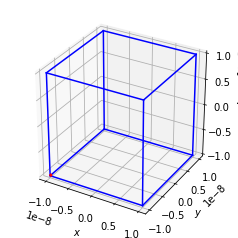

In [3]:
%matplotlib inline
mesh

As usual, we create the system object and define its Hamiltonian and dynamics equation.

In [7]:
import math
#System object
system = oc.System(name="cylinder")
# Hamiltonian
#A = 1.3e-11  # exchange energy constant (J/m)
H = (0, 0, 0.2e-3/oc.mu0)  # external magnetic field (A/m)
def A_value(pos):
    x, y, z = pos
    #r = math.sqrt((x-L/2)**2 + (y-L/2)**2)
    r = math.sqrt(x**2 + y**2)
    if r <= 4e-9:
        return 2.78e-11
    else:
        return 8.78e-11
    
#ex = df.Field(mesh, dim=1, value=A_value)
#ex.Region


#system.m = df.Field(mesh, value=(1, 0, 0), norm=Ms_function)
#print(type(system.m))
#oc.Exchange(system.m)
#system.m = df.Field(mesh, value=(1, 0, 0), norm=Ms_function)
#type(ex)
#type(system.m)
A =  df.Field(mesh, dim=1, value=A_value)
    
system.hamiltonian = oc.Exchange(A=ex) + oc.Demag() + oc.Zeeman(H)

## Dynamics
#gamma = 2.211e5
#alpha = 0.5
#system.dynamics = oc.Precession(gamma) + oc.Damping(alpha)

TypeError: Expected <class 'numbers.Real'>

In [ ]:
help(oc.Exchange)

The Hamiltonian and dynamics equation are:

In [ ]:
system.hamiltonian

In [ ]:
system.dynamics

### Defining cylinder geometry

In order to define cylinder geometry inside the rectangular mesh, we can define the saturation magnetisation function (we name it `Ms_function`), which depending on the position inside mesh $pos = (x, y, z)$ returns $M_\text{s}$ if the point is inside the culinder and $0$ otherwise:

$$
M_\text{s} =
  \begin{cases}
    8 \times 10^{5}, & \sqrt{x^{2} + y^{2}} \leq 50\,\text{nm} \\
    0, & \sqrt{x^{2} + y^{2}} > 50\,\text{nm}. \\
  \end{cases}
$$

In [ ]:
import math

def Ms_function(pos):
    x, y, z = pos
    r = math.sqrt(x**2 + y**2)
    if r>3.42e-9 and r <= 6.84e-9:
        return 8e5
    elif r <=3.42e-9:
        return 2e5
    else:
        return 0

Having the function defining the sphere geometry, we can now create the initial magnetisation field. The direction of the inital field is determined by the value variable, here $(1, 0, 0)$, i.e., the inital magnetization points into the $x$-direction and the norm should be the saturation magnetisation function we just created.

In [ ]:
system.m = df.Field(mesh, value=(1, 0, 0), norm=Ms_function)

In [ ]:
dir(system.m)
type(system.m)

We can plot the initial magnetisation by slicing the cylinder geometry perpendicular to "z" and "x" axes.

In [ ]:
system.m.plot_plane("z")
system.m.plot_plane("x")

### Relaxing the magnetisation

After we defined all requited parameters of the system, we can relax the system using `MinDriver`.

In [ ]:
td = oc.MinDriver()
td.drive(system)

And plot the magnetisation in the same slices as before.

In [ ]:
system.m.plot_plane("z")
system.m.plot_plane("x")

<hr>
Cleaning up.  Temporary files were written.  You may want to remove them.

In [ ]:
!rm -rf cylinder